## Introduction

This tutorial will introduce you to the basic algorithm of principal component analysis, and how to use pyspark to reduce dimensions of image information and rebuild an image through visualization. Data sources such as images and videos have tremendous dimensions and lots of noise, and it is time-consuming to save all dimensions of data and build a model with them. Therefore it is essential to compress data without losing too much information.

Component analysis is an unsupervised approach to find the "right" features from the data. The goal of component analysis is to represent high-dimensional data in a lower-dimensional subspace, on which we can build effecitve data analyses such as classification, clustering and pattern recognization. Principle component analysis (PCA) is the most common form of factor analysis. It projects multiple dimensions of data to singe dimension which best describes the data in a least-squares sense.

## Installing PySpark
In order to run codes in this tutorial, you will want to install PySpark on your machine using pip:

    $ pip install pyspark

After you run all the install, make sure the following commands work for you:

In [1]:
import pyspark
conf = pyspark.SparkConf()
conf.set("spark.executor.memory", "20g")
conf.set("spark.driver.memory", "20g")
conf.set("spark.core.connection.ack.wait.timeout", "12000")

sc = pyspark.SparkContext(conf=conf)

import matplotlib.pyplot as plt
import numpy as np

## Steps of PCA
### Interpreting PCA
PCA can be interpreted as identifying the "directions" along which the data vary the most. In the first step of PCA, we must first center our data. Working with correlated dataset, first compute the mean of each feature (column) in the dataset. Then for each observation, modify the features by subtracting their corresponding mean, to create a zero mean dataset.


Below are templates for generating plot layout and random dataset given covariance.

In [2]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color = gridColor, linewidth=gridWidth)
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

def create2DGaussian(mn, sigma, cov, n):
    np.random.seed(142)
    return np.random.multivariate_normal(np.array([mn, mn]), np.array([[sigma, cov], [cov, sigma]]), n)

Generate layout of 2 dimensional data with 0.6 covariance:

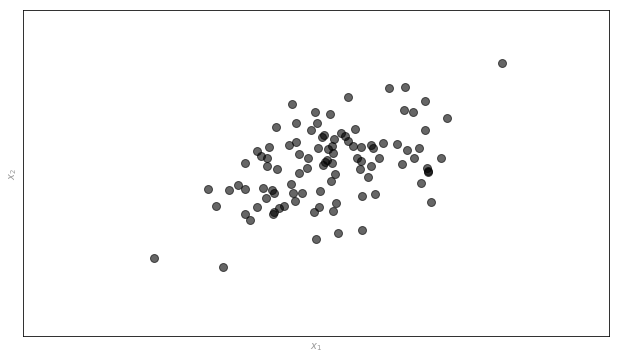

In [130]:
dataCorrelated = create2DGaussian(mn=50, sigma=1, cov=0.6, n=100)

# generate layout and plot data
fig, ax = preparePlot(np.arange(-12, 35), np.arange(-12, 35))
ax.set_xlabel(r'$x_1$'), ax.set_ylabel(r'$x_2$')
ax.set_xlim(45, 54.5), ax.set_ylim(45, 54.5)
ax.grid(False)
plt.scatter(dataCorrelated[:,0], dataCorrelated[:,1], s=8**2, c='0', alpha=0.6)
plt.show()

Create a zero mean dataset of the dummy correlated data.

### Covariance Matrix
If we define  $\scriptsize \mathbf{X} \in \mathbb{R}^{n \times d}$as the zero mean data matrix, then the sample covariance matrix is defined as:$$ \mathbf{C}_{\mathbf X} = \frac{1}{n} \mathbf{X}^\top \mathbf{X} \,.$$
 
To compute this matrix, compute the outer product of each data point, add together these outer products, and divide by the number of data points. The data are two dimensional, so the resulting covariance matrix should be a 2x2 matrix.

In [4]:
def estimateCovariance(data):
    """Compute the covariance matrix for a given rdd.
    The multi-dimensional covariance array should be calculated using outer products.
    Normalize the data by first subtracting the mean.

    Args:
        data (RDD of np.ndarray):  An `RDD` consisting of NumPy arrays.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input `RDD`.
    """
    dataMean = data.mean()
    dataZeroMean = data.map(lambda x: x - dataMean)
    return dataZeroMean.map(lambda x: np.outer(x, x)).sum() / data.count()


correlatedData = sc.parallelize(dataCorrelated)
correlatedCov= estimateCovariance(correlatedData)
print(correlatedCov)

[[1.01345737 0.53913961]
 [0.53913961 1.17953804]]


### Eigendecomposition
We've computed the sample covariance matrix, we can use it to find directions of maximal variance in the data.  Specifically, we can perform an eigendecomposition of this matrix to find its eigenvalues and eigenvectors.  The $\scriptsize d $ eigenvectors of the covariance matrix give us the directions of maximal variance, and are often called the "principal components."  The associated eigenvalues are the variances in these directions.  In particular, the eigenvector corresponding to the largest eigenvalue is the direction of maximal variance (this is sometimes called the "top" eigenvector). Eigendecomposition of a $\scriptsize d \times d $ covariance matrix has a (roughly) cubic runtime complexity with respect to $\scriptsize d $.  Whenever $\scriptsize d $ is relatively small (e.g., less than a few thousand) we can quickly perform this eigendecomposition locally.
 
Use a function from `numpy.linalg` called [eigh](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) to perform the eigendecomposition.  Next, sort the eigenvectors based on their corresponding eigenvalues (from high to low), yielding a matrix where the columns are the eigenvectors (and the first column is the top eigenvector).  Note that [np.argsort](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html#numpy-argsort) can be used to obtain the indices of the eigenvalues that correspond to the ascending order of eigenvalues.  Finally, set the `topComponent` variable equal to the top eigenvector or prinicipal component, which is a $\scriptsize 2 $-dimensional vector (array with two values).
Note that the eigenvectors returned by `eigh` appear in the columns and not the rows.  For example, the first eigenvector of `eigVecs` would be found in the first column and could be accessed using `eigVecs[:,0]`.

In [5]:
from numpy.linalg import eigh

# Calculate the eigenvalues and eigenvectors from correlatedCovAuto
eigVals, eigVecs = eigh(correlatedCov)
print ('eigenvalues: {0}'.format(eigVals))
print('\n')
print ('eigenvectors: {0}'.format(eigVecs))

# Use np.argsort to find the top eigenvector based on the largest eigenvalue
inds = np.argsort(eigVals)
topComponent = eigVecs[:,inds[-1]]
print('\n')
print ('top principal component: {0}'.format(topComponent))

eigenvalues: [0.55100049 1.64199492]


eigenvectors: [[-0.75902197  0.65106501]
 [ 0.65106501  0.75902197]]


top principal component: [0.65106501 0.75902197]


## PCA function

Compute the top k principal components and principal scores for a given dataset.

In [6]:
"""
The function below returns tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): 
A tuple of (eigenvectors, `RDD` ofscores, eigenvalues).  Eigenvectors is a multi-dimensional array 
where the number of rows equals the length of the arrays in the input `RDD` and the number of columns equals
`k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
of length `k`.  Eigenvalues is an array of length d (the number of features).
"""

def pca(data, k=2):
    eigVals, eigVecs = eigh(estimateCovariance(data))
    inds = np.argsort(eigVals)
    topkComponent = eigVecs[:,inds[-1: -k-1: -1]]
    scores = data.map(lambda x: x.dot(topkComponent))
    # Return the `k` principal components, `k` scores, and all eigenvalues
    return (topkComponent, scores, eigVals)

# Run pca on correlatedData with k = 2
topComponentsCorrelated, correlatedDataScoresAuto, eigenvaluesCorrelated = pca(correlatedData, 2)

# first principal component is in the first column
print ('topComponentsCorrelated: \n{0}'.format(topComponentsCorrelated))
print ('\ncorrelatedDataScoresAuto (first three): \n{0}'
       .format('\n'.join(map(str, correlatedDataScoresAuto.take(3)))))
print ('\neigenvaluesCorrelated: \n{0}'.format(eigenvaluesCorrelated))

# Create a higher dimensional test set
pcaTestData = sc.parallelize([np.arange(x, x + 4) for x in np.arange(0, 20, 4)])
componentsTest, testScores, eigenvaluesTest = pca(pcaTestData, 3)

print ('\npcaTestData: \n{0}'.format(np.array(pcaTestData.collect())))
print ('\ncomponentsTest: \n{0}'.format(componentsTest))
print ('\ntestScores (first three): \n{0}'
       .format('\n'.join(map(str, testScores.take(3)))))
print ('\neigenvaluesTest: \n{0}'.format(eigenvaluesTest))

topComponentsCorrelated: 
[[ 0.65106501 -0.75902197]
 [ 0.75902197  0.65106501]]

correlatedDataScoresAuto (first three): 
[70.38428468 -4.81628216]
[69.25859173 -5.00314943]
[70.90309502 -5.59497714]

eigenvaluesCorrelated: 
[0.55100049 1.64199492]

pcaTestData: 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]

componentsTest: 
[[ 5.00000000e-01  0.00000000e+00 -6.12372436e-01]
 [ 5.00000000e-01 -6.99362418e-17 -3.73226124e-01]
 [ 5.00000000e-01 -7.07106781e-01  4.92799280e-01]
 [ 5.00000000e-01  7.07106781e-01  4.92799280e-01]]

testScores (first three): 
[3.         0.70710678 2.09077028]
[11.          0.70710678  2.09077028]
[19.          0.70710678  2.09077028]

eigenvaluesTest: 
[-2.42594465e-14 -4.16226298e-15  0.00000000e+00  1.28000000e+02]


## PCA projection
Plot the original data and the 1-dimensional reconstruction using the top principal component to see how the PCA solution looks. The original data is plotted as before; however, the 1-dimensional reconstruction (projection) is plotted in grey on top of the original data and the vectors (lines) representing the two principal components are shown as orthogonal lines.

In [7]:
def projectPointsAndGetLines(data, components, xRange):
    """Project original data onto first component and get line details for top two components."""
    topComponent= components[:, 0]
    slope1, slope2 = components[1, :2] / components[0, :2]

    means = data.mean()[:2]
    demeaned = data.map(lambda v: v - means)
    projected = demeaned.map(lambda v: (v.dot(topComponent) /
                                        topComponent.dot(topComponent)) * topComponent)
    remeaned = projected.map(lambda v: v + means)
    x1,x2 = zip(*remeaned.collect())

    lineStartP1X1, lineStartP1X2 = means - np.asarray([xRange, xRange * slope1])
    lineEndP1X1, lineEndP1X2 = means + np.asarray([xRange, xRange * slope1])
    lineStartP2X1, lineStartP2X2 = means - np.asarray([xRange, xRange * slope2])
    lineEndP2X1, lineEndP2X2 = means + np.asarray([xRange, xRange * slope2])

    return ((x1, x2), ([lineStartP1X1, lineEndP1X1], [lineStartP1X2, lineEndP1X2]),
            ([lineStartP2X1, lineEndP2X1], [lineStartP2X2, lineEndP2X2]))

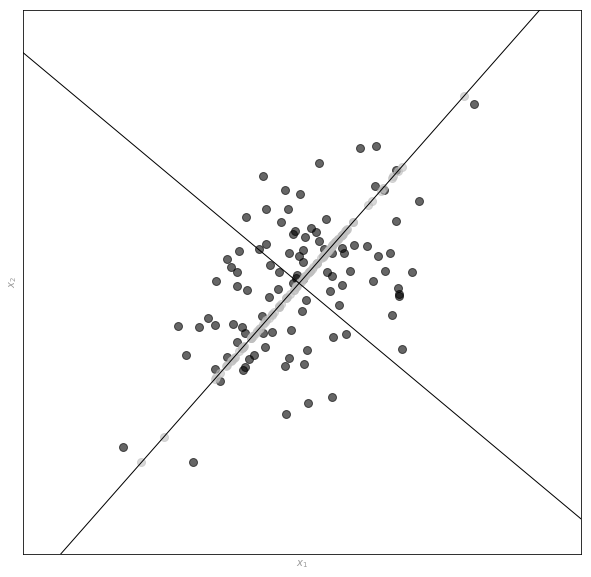

In [8]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    projectPointsAndGetLines(correlatedData, topComponentsCorrelated, 5)

# generate layout and plot data
fig, ax = preparePlot(np.arange(-12, 35, 2), np.arange(-12, 35, 2), figsize=(10, 10))
ax.set_xlabel(r'$x_1$'), ax.set_ylabel(r'$x_2$')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
ax.grid(False)
plt.plot(line1X1, line1X2, linewidth=1.0, c='0', linestyle='-')
plt.plot(line2X1, line2X2, linewidth=1.0, c='0', linestyle='-')
plt.scatter(dataCorrelated[:,0], dataCorrelated[:,1], s=8**2, c='0', alpha=0.6)
plt.scatter(x1, x2, s=8**2, c='0.75', alpha=.6)
plt.show()

## Application of PCA: human face reconstruction
Next, we will look into recognizing human face with PCA. In this situation, number of features (N x N pixel image) >> number of data points (examples). Since Images of faces are similar in overall configuration, and will not be randomly  distributed in this huge image space, they can be described by a low dimensional subspace.
### The main idea of PCA for face reconstruction:
1. To find vectors that best account for variation of face images in entire image space.
2. These vectors are what we call the eigen-vectors.
3. Construct a face space and project the images into this face space (eigenfaces).

In [65]:
import scipy.misc as smp
from PIL import Image

First, import 400 face images and show the first 20 faces. Data is downloaded from http://www.face-rec.org/databases/.

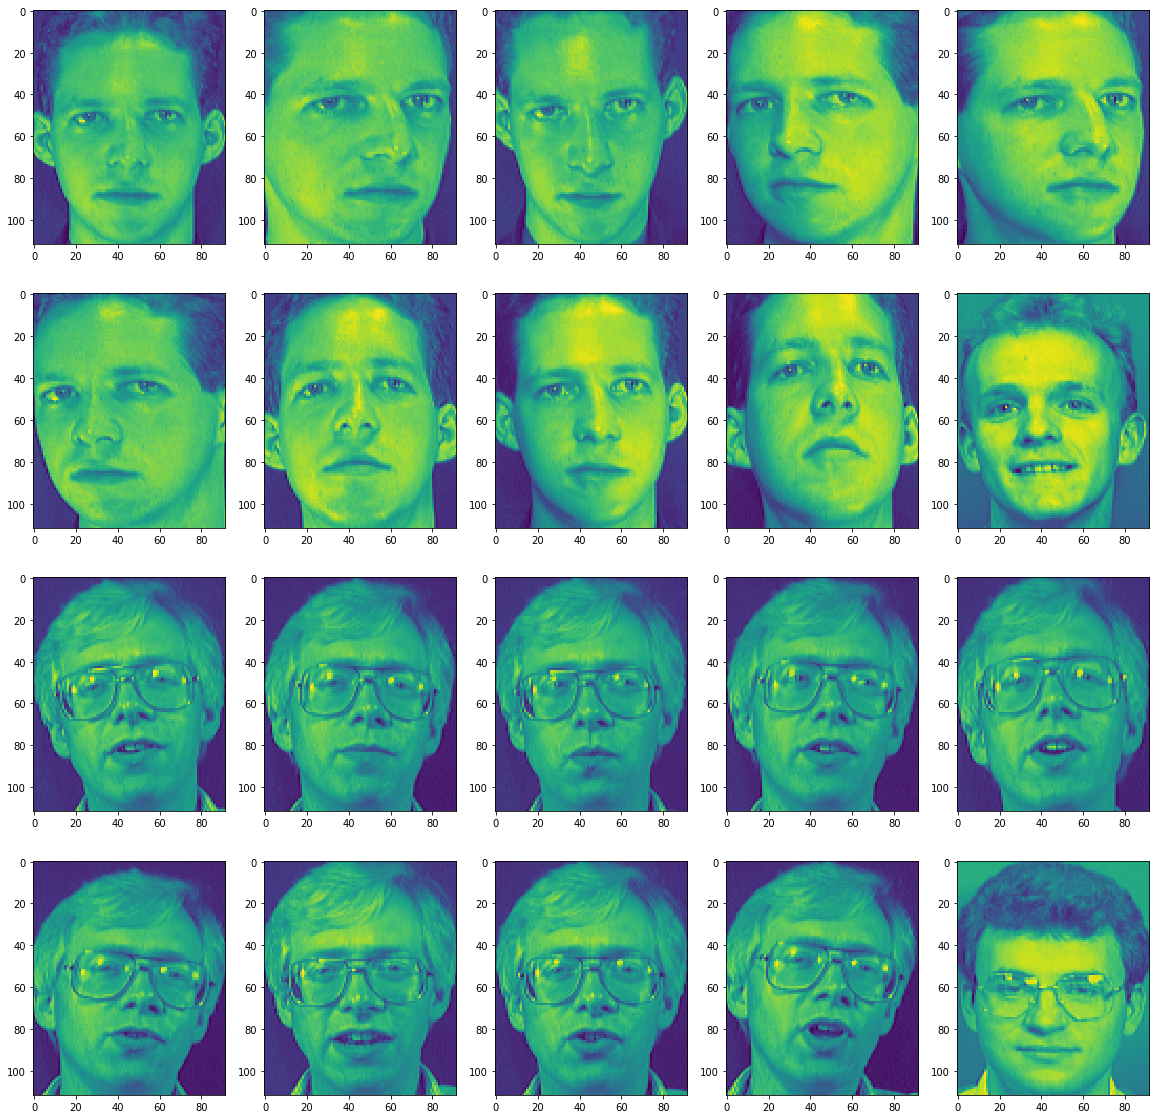

In [125]:
plt.figure(figsize = (20,20))
faceDataArray = np.array([])
for i in range(11, 411):
    pil_im = Image.open('ATTfaces/faces/s' + str(i) + '.pgm', 'r')
    twoDArray = np.array(pil_im).astype(float)
    if i < 31:
        plt.subplot(4, 5, i - 10)
        plt.imshow(twoDArray)
    if (i == 11):
        faceDataArray = np.hstack((faceDataArray, twoDArray.flatten()))
    else:
        faceDataArray = np.vstack((faceDataArray, twoDArray.flatten()))

plt.show()

Then, compute the top 10 principle components (eigenfaces) using the pca function above and visualize them.

### Matrix transform
The computation of covariance matrix of a dataset with 400 rows and 10304 columns are very expensive. Since the data dimension is 10304, the matrix size is 10304$\times$10304. So we want to simplify the computation through matrix transformation. Consider the eigenvectors $v_i$ of $XX^\top$ such that $$XX^\top v_i = \mu_i v_i$$premultiplying both sides by $X^\top$, we have $$X^\top XX^\top v_i = \mu_i X^\top v_i$$ same as $$X^\top X(X^\top v_i) = \mu_i (X^\top v_i)$$ We notice that $X^\top v_i$ equals eigenvectors of $X^\top X$, and the enginvalues equal. Therefore, to compute eigenvectors of $X^\top X$, we only have to compute eigenvectors of $X X^\top$ and multiply it by $X^\top$. The product are so-called eigenfaces.

We could slightly modify the code of estimateCovariance and pca to get the top k components...

In [126]:
def estimateCovarianceInner(data):
    np_mean = np.mean(data, axis=0)
    np_mean_rep = np.array([[np_mean],] * data.shape[0])
    dataZeroMean = data - np_mean
    matrix = np.asmatrix(data)
    inner = np.inner(matrix, matrix)
    return inner / np.linalg.norm(inner)

def pca(data, k=2):
    eigVals, eigVecs = eigh(estimateCovarianceInner(data))
    inds = np.argsort(eigVals)
    topkComponent = eigVecs[:,inds[-1: -k-1: -1]]
    topkComponent = topkComponent / np.linalg.norm(topkComponent)
    # Return the `k` principal components, `k` scores, and all eigenvalues
    return (topkComponent, eigVals)

Train the model with input data, and visualize the top 10 eigenfaces.

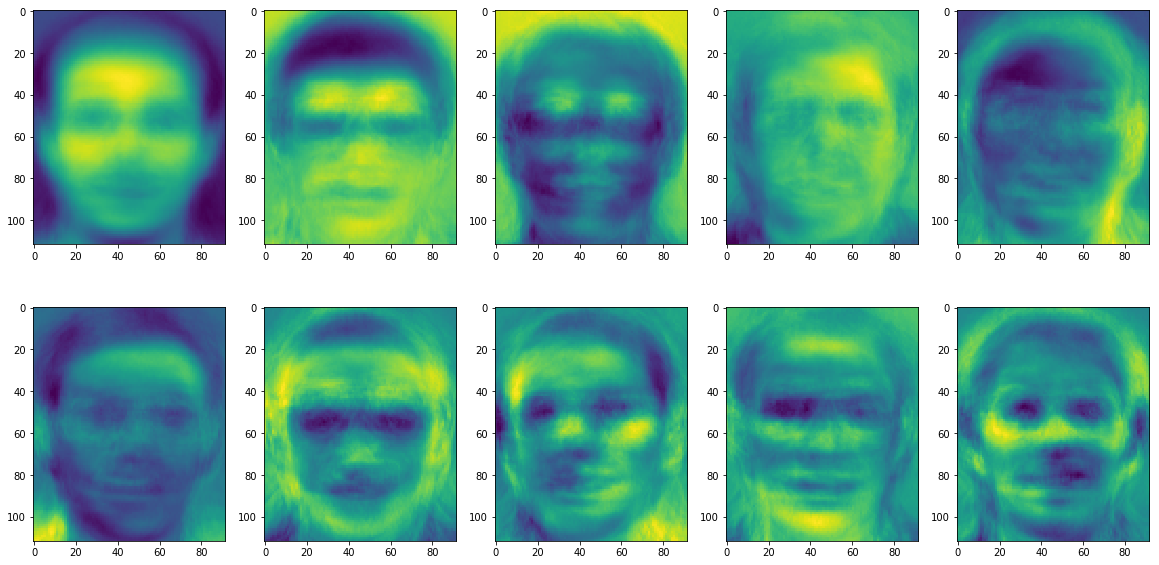

In [127]:
topEngVecs, eigVals = pca(faceDataArray, 30)
eigFace = np.dot(topEngVecs.transpose(), faceDataArray)
plt.figure(figsize = (20,10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(eigFace[i].reshape(112, 92))
plt.show()

### Human Face Projection using Eigenfaces
To test image, array (112$\times$92) of each image is projected into the face space to obtain a $10\times1$ vector, which indicates the relationship between the raw image and eigenfaces. Thus we can rebuild the image with much lower dimension and information loss.

In [128]:
face_mean = np.mean(faceDataArray, axis=0)
face_mean_rep = np.array([face_mean,] * 20)
proj_20faces = np.dot(faceDataArray[:20,:] - face_mean_rep, eigFace.transpose())
tenEigenFaceProj = proj_20faces / np.linalg.norm(proj_20faces)
print ('Projection of first 3 images with 10 eigen faces: \n{0}'.format(tenEigenFaceProj[:3,:]))

Projection of first 3 images with 10 eigen faces: 
[[ 2.29165886e-01 -3.67909152e-03 -1.76743255e-02  6.54775424e-03
   2.80023571e-03 -6.26236442e-03  1.71274569e-03 -8.44543620e-04
   5.50796795e-03 -5.18964874e-03  1.75815835e-03 -1.15888696e-03
   1.09865508e-03 -9.26571908e-04 -3.84001744e-04  3.25503485e-04
  -3.33016722e-04  2.53191346e-03 -1.57774728e-03  2.89133415e-04
  -7.49450076e-04  8.38959843e-04 -1.57533022e-03  2.18427777e-04
  -5.22515125e-05  5.10432699e-04 -5.15656964e-04  1.85702126e-04
   5.70897500e-04 -1.00010906e-03]
 [ 3.87756428e-01 -2.13333907e-02  3.39563705e-03 -1.32834548e-02
   1.47297590e-02 -7.90025388e-03  3.82179919e-03 -7.60858427e-03
   5.76004383e-03  3.63775942e-04 -1.71617282e-03 -1.17093622e-03
  -3.15407123e-04  4.20736363e-03  1.76408169e-03  6.26870782e-04
  -1.09207336e-03  1.64016745e-03  1.64331675e-03  1.83371646e-03
  -1.96895545e-03 -1.83579788e-03  3.49014111e-04  1.75406621e-04
  -6.79965836e-04 -4.43903516e-04  2.27405241e-04 -1.659

After computing the eigen faces and the projections, we could now reconstruct the face!

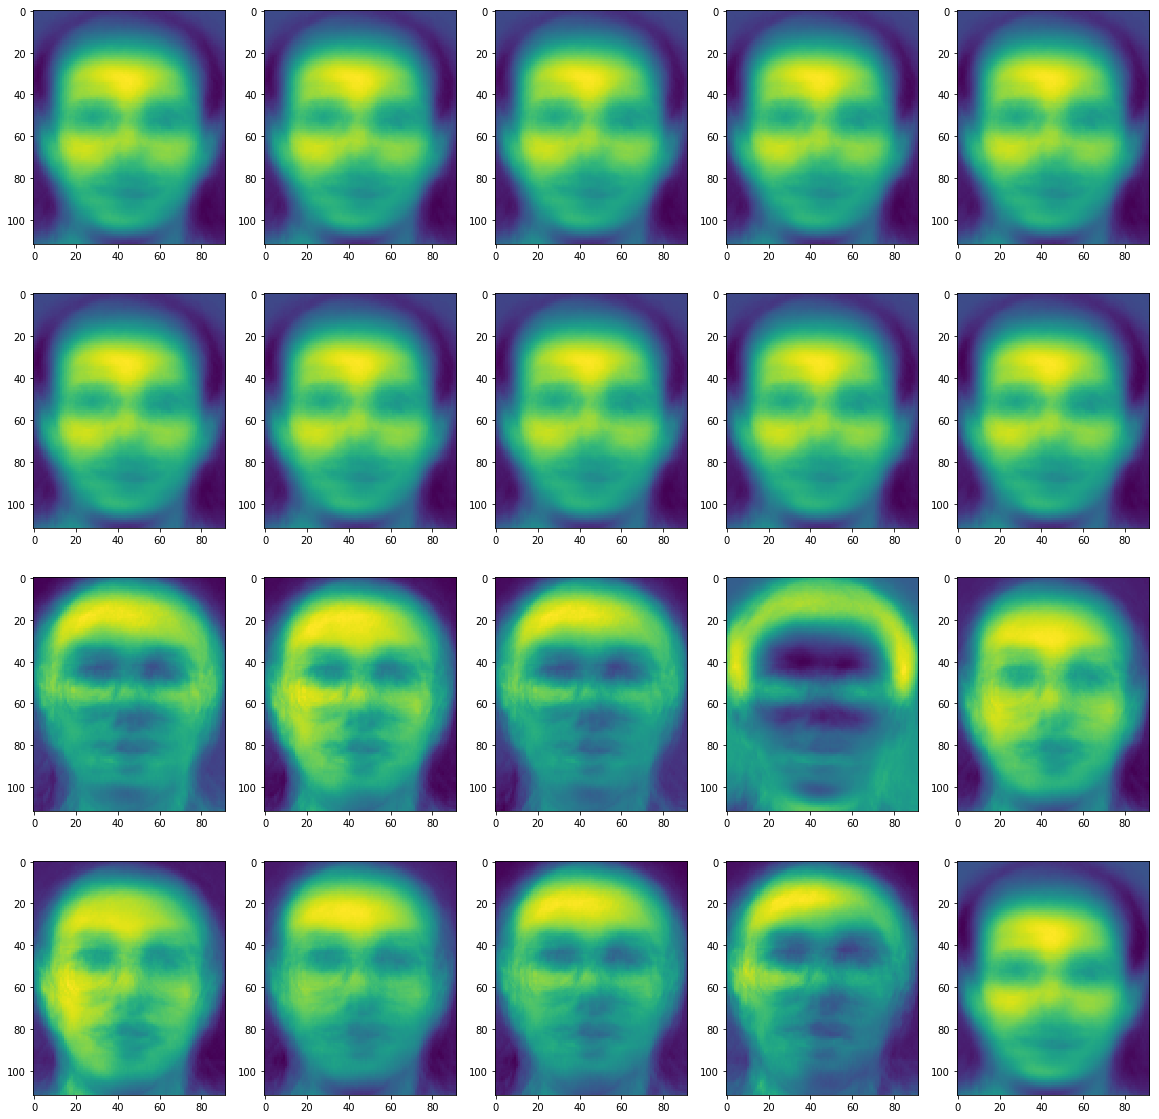

In [129]:
rebuildFaces = np.dot(tenEigenFaceProj, eigFace)
plt.figure(figsize = (20,20))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(rebuildFaces[i].reshape(112, 92))
plt.show()

## Summary and references
This tutorial only introduces basic algorithm of dimensional reduction and a simple application. Much more detail about the libraries and questions are available from the following links.

1. https://spark.apache.org/docs/latest/mllib-dimensionality-reduction.html
2. http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
3. https://docs.opencv.org/3.1.0/d1/dee/tutorial_introduction_to_pca.htmlhttps://docs.opencv.org/3.1.0/d1/dee/tutorial_introduction_to_pca.html